In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#import libraries
import time
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet') 
nltk.download('tagsets') 
nltk.download('averaged_perceptron_tagger') 
import matplotlib.pyplot as plt
import seaborn as sns
#Data Cleaning
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
import string
#Model Evaludation
from sklearn.metrics import accuracy_score
from sklearn import metrics
#Model Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


In [0]:
#Stemmer and Lemmatizer intialization
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()*"

In [0]:
#utility function to clean the dataset

def datacleaning(remove_stopwords,useStemming,useLemma,removePuncs,newdata):
  cleanReview=[]
  for x in range(0,len(newdata.values)):
    tmpReview=[]
    for w in nltk.word_tokenize(newdata.values[x]):
        newWord = str(w).lower() #Set newWork to be the updated word
        if remove_stopwords and (w in stopwords_en):#if the word is a stopword & we want to remove stopwords
            continue #skip the word and don’t had it to the normalized review
        if removePuncs and (w in punctuations):#if the word is a punc. & we want to remove punctuations
            continue #skip the word and don’t had it to the normalized review
        if useStemming: #if useStemming is set to True
            #Keep one stemmer commented out
            #newWord = porter.stem(newWord) #User porter stemmer
            newWord = lancaster.stem(newWord) #Use Lancaster stemmer
        if useLemma:
            newWord = wordnet_lemmatizer.lemmatize(newWord)
        tmpReview.append(newWord) #Add normalized word to the tmp review
    cleanReview.append(' '.join(tmpReview))
  return cleanReview

In [0]:
url="/content/drive/My Drive/NLP/Combined_News_DJIA.csv"
dataset = pd.read_csv(url,encoding = "ISO-8859-1")

In [0]:
dataset.shape

(1989, 27)

In [0]:
dataset.head(5)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [0]:
#Count of Each Sentiment
df_plot=dataset['Label'].value_counts()

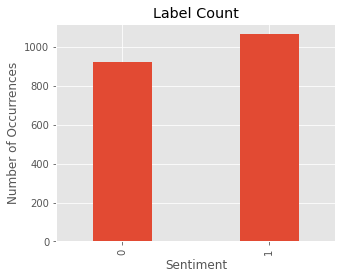

In [0]:
#Plot the sentiment class count
plt.style.use("ggplot")
plt.figure(figsize=(5,4))
fig = dataset.groupby('Label').Top1.count().plot.bar(ylim=0, width=0.4)
plt.title('Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()

In [0]:
#Split the dataset in Test Train
X_train, X_test, Y_train, Y_test = train_test_split(dataset.iloc[:,2:],dataset['Label'], test_size=0.3, random_state=2003)

In [0]:
Y_train.value_counts()

1    734
0    658
Name: Label, dtype: int64

In [0]:
X_train.shape

(1392, 25)

Train Data Preprocessing

In [0]:
#Combine all the top heading in a list
headlines = []
for row in range(0,len(X_train.index)):
    headlines.append(' '.join(str(x) for x in X_train.iloc[row,0:]))

In [0]:
#Add the list as column to the X_train dataframe
X_train['Combined']=headlines

In [0]:
X_train.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined
193,b' Unsung hero : The only reason we know anyth...,"b""Noticed an unusual, strong burst of pro-isra...",b'The world elite meets again for Bilderberg: ...,b' Boycott Israel campaign starts to bite',"b'""If you are watching this message, it is bec...",b'Muslim famous for predicting a totally Islam...,b'Australian immigration authorities told a de...,b'Guatemala arrests Twitter user for inciting ...,"b'Our man at Bilderberg: Close, but still no c...","b""Our man at Bilderberg: in pursuit of the wor...","b""'Slumdog' (Salim) child star's home torn down""",b'Author Dan Brown feels the wrath of Catholics',b'Sweden wants to force ISPs to save user data',b'German government has predicted the economy ...,b'Bishop of Baghdad worried that Christianity ...,b'Piratebay DDo$ attack site (http://interneta...,b'Thousands flee Pakistan fighting',"b'Polica Nacional del Per: Gay Sex ""Tarnishes""...","b""Shadowy Bilderberg group meet in Greece--and...",b'Vietnam veteran on spiritual quest lands Aun...,b'Avigdor Lieberman - To ban Israeli Arabs fro...,b'Paul Craig Roberts on the Global Anti-Semiti...,"b'The rich, shadowy Bilderberg group'","b""The World's Best Illusion: The Secret of the...","b""Defining 'Success' Down""",b' Unsung hero : The only reason we know anyth...
1339,Police kill someone in Iceland.. for the first...,Pope Francis secretly sneaks out at night to h...,An entire village is sealed off by gendarmes a...,Stephen Hawking: NHS is Britain's finest publi...,"1,200-year-old Malaysian temple ruin razed by ...",Spain And Japan Move To Criminalize Protests,UK politician who made speech implying rich pe...,North Korea's second-most-powerful man and hus...,Anti-gay Russian group upload video of them ph...,"Are you one of the 700,000 people on the U.S. ...",Ukraine's crisis is getting so serious that pr...,Hong Kong confirms first human case of bird flu,BP wins U.S. appeals court reprieve over some ...,Guantnamo Bay detainees claim Poland allowed C...,Guardian Australia fiercely defends its report...,Zimbabwe gives Chinese man $150 fine for $320 ...,Yuan Passes Euro as Second-Most Used Trade-Fin...,Tim Berners-Lee: Spies' cracking of encryption...,Dredging set to swamp decades of Great Barrier...,The Spanish region of Catalonia wants to revok...,US singer and song writer Bob Dylan has been p...,"BBC News - Ukraine PM says he ""sees all signs ...",The UN's senior counter-terrorism official is ...,"Australian Security service, ASIO has raided C...",Mexico: Thousands Protests Against Oil Industr...,Police kill someone in Iceland.. for the first...


In [0]:
#Final Train data frame
train_data=pd.concat([X_train['Combined'],Y_train],axis=1)

In [0]:
train_data.shape

(1392, 2)

In [0]:
train_data.head(2)

,Combined,Label
193,b' Unsung hero : The only reason we know anyth...,0
1339,Police kill someone in Iceland.. for the first...,0


In [0]:
#clean the data and concat the clean text to the train_data
temp_train_phrase=datacleaning(True,False,True,True,train_data['Combined'])
train_data['Cleaned']=temp_train_phrase

In [0]:
train_data.head(2)

,Combined,Label,Cleaned
193,b' Unsung hero : The only reason we know anyth...,0,b unsung hero the reason know anything claim l...
1339,Police kill someone in Iceland.. for the first...,0,police kill someone iceland.. first time ever ...


In [0]:
Y_train.value_counts()

1    734
0    658
Name: Label, dtype: int64

Feature Engineering and Model Training

In [0]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(train_data['Label'])
#Test_Y = Encoder.fit_transform(y_test)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
countvector=TfidfVectorizer(ngram_range=(2,2), max_features=5000)
Train_X_Tfidf = countvector.fit_transform(train_data['Cleaned'])
#Test_X_Tfidf = countvector.transform(headline_test_stem)

In [0]:
from sklearn.svm import SVC
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Model Testing

In [0]:
X_test.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
256,"b'Americans pay $635.85 on cell phone service,...",b'Who is funding the Afghan Taliban? You dont ...,"b""New Afgan law: husbands can deny food to wiv...",b'WTF: Britain sleepwalked into a surveillance...,"b'An enormous system of caves, chambers and tu...",b'A woman with a prosthetic arm wins her case ...,b'Solution to Israel/Palestine conflict at han...,"b'Britons, from all sides of the political spe...",b'Thousands of people are flocking to a remote...,"b""The Madness of Japan's Happiness Party which...","b'School pupil, 90, dies in Kenya'","b""Iran's defeated opposition presidential cand...",b'UN rights chief slams Israel over Gaza viola...,"b'""One rabbi told soldiers in a pep talk durin...",b'UK imposes Turks and Caicos rule',"b'Manson ""family"" member released'","b""Antarctic glacier 'thinning fast'""",b'Man accused of raping woman he met on couchs...,b'Tories say earning in the 99.9th percentile ...,"b'A wounded pirate, found on a beach with mach...","b""Deadly game of Kenya's gem trade""",b'Israeli police have launched a major securit...,"b""NHS attack by right wing MEP on US TV 'unpat...","b""Crews 'overpower Somali pirates'""","b'Mosque gun battle rages in Gaza, hundreds of..."
949,"In a landmark case in Finland, a court has rul...",Less affluent countries push towards universal...,Rebekah Brooks to be charged with perverting t...,Anders Breivik Trial: A man just set himself o...,"China builds ""instant high rise"" in just 9 days","Greece fails to form new government, going to ...",Rebekah Brooks to be charged over News Interna...,Why so little condemnation of Israel's extremi...,Japanese rivers continue to contaminate Tokyo ...,Time to Admit Defeat Greece Can No Longer Dela...,"""Unless the world addresses the problem, by 20...",Asian Girls Getting Plastic Surgery to Widen T...,"Carlos Fuentes, Mexican Writer, Dies at 83",Britain Bedeviled by Binge Drinking - It's rea...,EU Makes 1st Air Strikes Against Somalia Pirat...,"[ALJAZEERA] - WWF announces ""we are living as ...",France's Hollande's plane hit by lightning en ...,Aging Europeans Need to Work Longer &amp; Expe...,"More than 1,500 Palestinians prisoners that ha...",Black Metal musician elected to Greek parliament,Iran Hangs 'Israel Killer Spy' - Majid Jamali ...,More horror in Mexico: 49 mutilated bodies dum...,- Forensic police swarmed the crypt of a Roman...,Debate Breaks Out in Germany over Foreign Gold...,Blockupy Frankfurt is already somewhat succesf...


In [0]:
X_test.shape

(597, 25)

Test Data Preprocessing

In [0]:
#Combine the top headline in to list for test data
headlines_test = []
for row in range(0,len(X_test.index)):
    headlines_test.append(' '.join(str(x) for x in X_test.iloc[row,0:]))

In [0]:
#Adding the combined healines as column to test data
X_test['Combined']=headlines_test

In [0]:
#New dataframe having only required data
test_data=pd.concat([X_test['Combined'],Y_test],axis=1)

In [0]:
test_data.head(2)

,Combined,Label
256,"b'Americans pay $635.85 on cell phone service,...",0
949,"In a landmark case in Finland, a court has rul...",0


In [0]:
test_data.shape

(597, 2)

In [0]:
test_data['Label'].value_counts()

1    331
0    266
Name: Label, dtype: int64

In [0]:
#Clean the test data and add the clean data as column to test_data
#preprocess(test_data['Combined'])
temp_test_phrase=datacleaning(True,False,True,True,test_data['Combined'])
test_data['Cleaned']=temp_test_phrase

In [0]:
test_data.head(2)

,Combined,Label,Cleaned
256,"b'Americans pay $635.85 on cell phone service,...",0,b'americans pay $ 635.85 cell phone service co...
949,"In a landmark case in Finland, a court has rul...",0,in landmark case finland court ruled open wifi...


Feature Vector Generation

In [0]:
Test_Y = Encoder.fit_transform(test_data['Label'])

In [0]:
Test_X_Tfidf = countvector.transform(test_data['Cleaned'])

Test Model

In [0]:
test_data['Label'].value_counts()

1    331
0    266
Name: Label, dtype: int64

In [0]:
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  51.42378559463987


In [0]:
# Import library to check accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

Model Performance

Confusion Matrix
[[119 147]
 [143 188]]


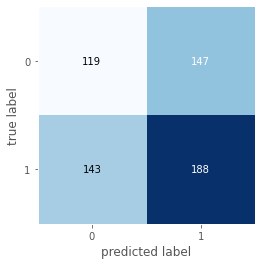


Model Accuracy: 0.51
Model F1Score: 0.51
Model Precision: 0.51
Model Recall: 0.51

Complete Classification report
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       266
           1       0.56      0.57      0.56       331

    accuracy                           0.51       597
   macro avg       0.51      0.51      0.51       597
weighted avg       0.51      0.51      0.51       597



In [0]:
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
matrix=confusion_matrix(test_data['Label'],predictions_SVM)
print("Confusion Matrix")
print(matrix)
fig, ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()
#plt.savefig('/content/drive/My Drive/NLP_Project/RF_CF.png', format='png', dpi=1200)

score=accuracy_score(test_data['Label'],predictions_SVM)
print('\nModel Accuracy: {:.2f}'.format(score))
print('Model F1Score: {:.2f}'.format(metrics.f1_score(test_data['Label'],predictions_SVM, average='weighted')))
print('Model Precision: {:.2f}'.format(metrics.precision_score(test_data['Label'],predictions_SVM, average='weighted')))
print('Model Recall: {:.2f}'.format(metrics.recall_score(test_data['Label'],predictions_SVM, average='weighted')))


report=classification_report(test_data['Label'],predictions_SVM)
print('\nComplete Classification report')
print(report)